In [30]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor

# 5. Define core functions and main function for Walk Forward Validation

def train_model_wf(X_train, y_train):
    # Create a pipeline with StandardScaler and SVC
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        #('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('svc', SVC(max_iter=1000000))
    ])
    pipe.fit(X_train, y_train)
    
    return pipe


def evaluate_model_wf(model, X_test, y_test):
    predictions = model.predict(X_test)
    return confusion_matrix(y_test, predictions)

def get_next_window_wf(data, start_index, train_window, test_window):
    print("args in", start_index, train_window, test_window)
    end_train_window = start_index + train_window
    start_test_window = end_train_window
    end_test_window = start_test_window + test_window
    
    train_data = data.iloc[start_index:end_train_window]
    test_data = data.iloc[start_test_window:end_test_window]
    print("testdata indices:", start_test_window,end_test_window)
    print("testdata length:", len(test_data))
    print("extracted month from",test_data.Open_time.min(),"to",test_data.Open_time.max())
    return train_data, test_data

def walk_forward_validation_wf(data, features, label, train_window, test_window):
    current_start = 0
    cm_results = []

    while current_start + train_window + test_window <= len(data):
        train_data, test_data = get_next_window_wf(data, current_start, train_window, test_window)
        model = train_model_wf(train_data[features], train_data[label])
        cm = evaluate_model_wf(model, test_data[features], test_data[label])
        cm_results.append(cm)
        current_start += test_window  

    return cm_results

# 6. Perform Walk Forward Validation
def simulate_trades_v3(data, predictions, close_col="Close"):
    """
    Simulation of trades using open_time for trade entry and exit points.
    """
    in_trade = False
    entry_price = 0
    gains = []
    trade_entries_times = []
    trade_exits_times = []

    for i in range(1, len(predictions)):
        if predictions[i] == 1 and predictions[i - 1] == 0:  # Buy signal
            in_trade = True
            entry_price = data[close_col].iloc[i]
            trade_entries_times.append(data["Open_time"].iloc[i])
            
        elif in_trade and predictions[i] == 0 and predictions[i - 1] == 1:  # Sell signal
            in_trade = False
            exit_price = data[close_col].iloc[i]
            gain = (exit_price - entry_price) / entry_price
            gains.append(gain)
            trade_exits_times.append(data["Open_time"].iloc[i])

    # If still in trade at the end, sell at last price
    if in_trade:
        exit_price = data[close_col].iloc[-1]
        gain = (exit_price - entry_price) / entry_price
        gains.append(gain)
        trade_exits_times.append(data["Open_time"].iloc[-1])

    return gains, trade_entries_times, trade_exits_times

def train_lof_model(X_train, contamination=0.0025):
    """
    Train the Local Outlier Factor (LOF) model.
    
    Parameters:
    - X_train: The training data.
    - contamination: The proportion of outliers in the data set.
    
    Returns:
    - A trained LOF model.
    """
    lof = LocalOutlierFactor(novelty=True, contamination=contamination)
    lof.fit(X_train)
    return lof

def walk_forward_validation_with_trades_v2(data, features, label, train_window, test_window, close_col="Close"):
    """
    Perform walk forward validation with trade simulation v2.
    """
    current_start = 0
    all_gains = []
    all_trade_entries = []
    all_trade_exits = []

    while current_start + train_window + test_window <= len(data):
        train_data, test_data = get_next_window_wf(data, current_start, train_window, test_window)
        model = train_model_wf(train_data[features], train_data[label])
        
        lof = train_lof_model(train_data[features])
        
        # Identify novelties in the test set
        lof_predictions = lof.predict(test_data[features])
        non_novelty_indices = np.where(lof_predictions == 1)[0]  # 1 indicates inliers, -1 indicates outliers/novelties
        
        # Predict only for non-novelty data
        svc_predictions = model.predict(test_data[features])#.iloc[non_novelty_indices])
        
        # Create a full-length prediction array for test_data and set predictions for novelties to 0 (or any default value)
        predictions = np.zeros(len(test_data))
        predictions[non_novelty_indices] = svc_predictions[non_novelty_indices]
        
        print("LOF FILTERED", np.count_nonzero(svc_predictions), "vs", np.count_nonzero(predictions))
        print("starting month from",test_data.Open_time.min(),"to",test_data.Open_time.max(), "oflen", len(test_data))
        print("confusion:", confusion_matrix(test_data['label'], predictions))
        
        if np.count_nonzero(predictions)>0:
            gains, trade_entries, trade_exits = simulate_trades_v3(test_data, predictions, close_col)
            print("gains:", sum(gains), "nr of trades", len(trade_exits))

            all_gains.extend(gains)
            all_trade_entries.extend(trade_entries)
            all_trade_exits.extend(trade_exits)
        
        current_start += test_window

    return all_gains, all_trade_entries, all_trade_exits
df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v2.csv')
df_trade["label"] = df_trade.label.replace(np.NaN,False)

HOURS_IN_MONTH = 24 * 30
TRAIN_WINDOW_SIZE = 6 * HOURS_IN_MONTH  
TEST_WINDOW_SIZE = 14*24#*HOURS_IN_MONTH


# Drop rows with NaN values
df_trade_cleaned = df_trade.replace(np.NaN,0)

# Convert boolean labels to binary (0 and 1)
df_trade_cleaned["label"] = df_trade_cleaned["label"].astype(int)

#df_trade_cleaned["priceCond1"] = df_trade_cleaned.Volume.pct_change().rolling(3*24).sum() > 0
# Extract features and label
features_trade = df_trade_cleaned.columns[df_trade_cleaned.columns.str.contains("Feature")].tolist()
label_trade = "label"

df_trade_cleaned.head()

# Perform Walk Forward Validation with the trade simulation v3
gains_v3, trade_entries_times_v3, trade_exits_times_v3 = walk_forward_validation_with_trades_v2(df_trade_cleaned, features_trade, label_trade, TRAIN_WINDOW_SIZE, TEST_WINDOW_SIZE)


# Constants for our data



"""# Plot cumulative gains and trade entry/exits using open_time v3
plt.figure(figsize=(15, 7))
plt.plot(df_trade_cleaned["Open_time"], df_trade_cleaned["Close"], label="Close Price", alpha=0.6)
#plt.plot(df_trade_cleaned["Open_time"], np.cumprod([1] + gains_v3), label="Cumulative Gain", color="green", lw=2)
plt.scatter(trade_entries_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_entries_times_v3)], marker="^", color="g", label="Trade Entry")
plt.scatter(trade_exits_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_exits_times_v3)], marker="v", color="r", label="Trade Exit")
plt.legend()
plt.title("Close Price with Trade Entry/Exits and Cumulative Gain (V3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


<ipython-input-30-a22259872653>:145: DtypeWarning: Columns (129) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v2.csv')


args in 0 4320 336
testdata indices: 4320 4656
testdata length: 336
extracted month from 2020-06-29 12:00:00 to 2020-07-13 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 125 vs 124
starting month from 2020-06-29 12:00:00 to 2020-07-13 11:00:00 oflen 336
confusion: [[136  57]
 [ 76  67]]
gains: 0.03842684560245306 nr of trades 27
args in 336 4320 336
testdata indices: 4656 4992
testdata length: 336
extracted month from 2020-07-13 12:00:00 to 2020-07-27 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 102 vs 97
starting month from 2020-07-13 12:00:00 to 2020-07-27 11:00:00 oflen 336
confusion: [[119  44]
 [120  53]]
gains: 0.11310282232778218 nr of trades 17
args in 672 4320 336
testdata indices: 4992 5328
testdata length: 336
extracted month from 2020-07-27 12:00:00 to 2020-08-10 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 65 vs 63
starting month from 2020-07-27 12:00:00 to 2020-08-10 11:00:00 oflen 336
confusion: [[135  26]
 [138  37]]
gains: 0.013428897833939586 nr of trades 9
args in 1008 4320 336
testdata indices: 5328 5664
testdata length: 336
extracted month from 2020-08-10 12:00:00 to 2020-08-24 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 41 vs 37
starting month from 2020-08-10 12:00:00 to 2020-08-24 11:00:00 oflen 336
confusion: [[212  25]
 [ 87  12]]
gains: -0.030858937483475544 nr of trades 10
args in 1344 4320 336
testdata indices: 5664 6000
testdata length: 336
extracted month from 2020-08-24 12:00:00 to 2020-09-07 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 30 vs 28
starting month from 2020-08-24 12:00:00 to 2020-09-07 11:00:00 oflen 336
confusion: [[197  18]
 [111  10]]
gains: -0.04038368177817245 nr of trades 7
args in 1680 4320 336
testdata indices: 6000 6336
testdata length: 336
extracted month from 2020-09-07 12:00:00 to 2020-09-21 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 96 vs 56
starting month from 2020-09-07 12:00:00 to 2020-09-21 11:00:00 oflen 336
confusion: [[166  38]
 [114  18]]
gains: 0.010114087420436905 nr of trades 10
args in 2016 4320 336
testdata indices: 6336 6672
testdata length: 336
extracted month from 2020-09-21 12:00:00 to 2020-10-05 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 88 vs 88
starting month from 2020-09-21 12:00:00 to 2020-10-05 11:00:00 oflen 336
confusion: [[136  42]
 [112  46]]
gains: 0.025444165994768213 nr of trades 19
args in 2352 4320 336
testdata indices: 6672 7008
testdata length: 336
extracted month from 2020-10-05 12:00:00 to 2020-10-19 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 143 vs 124
starting month from 2020-10-05 12:00:00 to 2020-10-19 11:00:00 oflen 336
confusion: [[121  90]
 [ 91  34]]
gains: -0.023121739250925533 nr of trades 13
args in 2688 4320 336
testdata indices: 7008 7344
testdata length: 336
extracted month from 2020-10-19 12:00:00 to 2020-11-02 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 49 vs 32
starting month from 2020-10-19 12:00:00 to 2020-11-02 11:00:00 oflen 336
confusion: [[175  26]
 [129   6]]
gains: -0.03792531201626132 nr of trades 10
args in 3024 4320 336
testdata indices: 7344 7680
testdata length: 336
extracted month from 2020-11-02 12:00:00 to 2020-11-16 11:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 52 vs 52
starting month from 2020-11-02 12:00:00 to 2020-11-16 11:00:00 oflen 336
confusion: [[157  18]
 [127  34]]
gains: 0.1313632149707683 nr of trades 12
args in 3360 4320 336
testdata indices: 7680 8016
testdata length: 336
extracted month from 2020-11-16 12:00:00 to 2020-11-30 12:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 37 vs 30
starting month from 2020-11-16 12:00:00 to 2020-11-30 12:00:00 oflen 336
confusion: [[147  10]
 [159  20]]
gains: 0.10124673944852798 nr of trades 7
args in 3696 4320 336
testdata indices: 8016 8352
testdata length: 336
extracted month from 2020-11-30 13:00:00 to 2020-12-14 12:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 202 vs 158
starting month from 2020-11-30 13:00:00 to 2020-12-14 12:00:00 oflen 336
confusion: [[123 105]
 [ 55  53]]
gains: 0.014489469044431613 nr of trades 15
args in 4032 4320 336
testdata indices: 8352 8688
testdata length: 336
extracted month from 2020-12-14 13:00:00 to 2020-12-28 16:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 104 vs 81
starting month from 2020-12-14 13:00:00 to 2020-12-28 16:00:00 oflen 336
confusion: [[131  43]
 [124  38]]
gains: 0.09074976485792033 nr of trades 15
args in 4368 4320 336
testdata indices: 8688 9024
testdata length: 336
extracted month from 2020-12-28 17:00:00 to 2021-01-11 16:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 7 vs 7
starting month from 2020-12-28 17:00:00 to 2021-01-11 16:00:00 oflen 336
confusion: [[159   5]
 [170   2]]
gains: -0.018289184108680204 nr of trades 3
args in 4704 4320 336
testdata indices: 9024 9360
testdata length: 336
extracted month from 2021-01-11 17:00:00 to 2021-01-25 16:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 121 vs 23
starting month from 2021-01-11 17:00:00 to 2021-01-25 16:00:00 oflen 336
confusion: [[173   5]
 [140  18]]
gains: 0.1288299695278754 nr of trades 7
args in 5040 4320 336
testdata indices: 9360 9696
testdata length: 336
extracted month from 2021-01-25 17:00:00 to 2021-02-08 16:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 178 vs 79
starting month from 2021-01-25 17:00:00 to 2021-02-08 16:00:00 oflen 336
confusion: [[159  40]
 [ 98  39]]
gains: 0.07477706062731157 nr of trades 21
args in 5376 4320 336
testdata indices: 9696 10032
testdata length: 336
extracted month from 2021-02-08 17:00:00 to 2021-02-22 17:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 111 vs 104
starting month from 2021-02-08 17:00:00 to 2021-02-22 17:00:00 oflen 336
confusion: [[163  46]
 [ 69  58]]
gains: 0.04502164136443611 nr of trades 29
args in 5712 4320 336
testdata indices: 10032 10368
testdata length: 336
extracted month from 2021-02-22 18:00:00 to 2021-03-08 18:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 224 vs 177
starting month from 2021-02-22 18:00:00 to 2021-03-08 18:00:00 oflen 336
confusion: [[123  88]
 [ 36  89]]
gains: 0.3936598969823606 nr of trades 30
args in 6048 4320 336
testdata indices: 10368 10704
testdata length: 336
extracted month from 2021-03-08 19:00:00 to 2021-03-22 18:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 113 vs 108
starting month from 2021-03-08 19:00:00 to 2021-03-22 18:00:00 oflen 336
confusion: [[168  76]
 [ 60  32]]
gains: 0.05418524790558176 nr of trades 20
args in 6384 4320 336
testdata indices: 10704 11040
testdata length: 336
extracted month from 2021-03-22 19:00:00 to 2021-04-05 18:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 104 vs 92
starting month from 2021-03-22 19:00:00 to 2021-04-05 18:00:00 oflen 336
confusion: [[112  41]
 [132  51]]
gains: 0.097889299355104 nr of trades 10
args in 6720 4320 336
testdata indices: 11040 11376
testdata length: 336
extracted month from 2021-04-05 19:00:00 to 2021-04-19 18:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 50 vs 40
starting month from 2021-04-05 19:00:00 to 2021-04-19 18:00:00 oflen 336
confusion: [[149  27]
 [147  13]]
gains: 0.04890485037268072 nr of trades 15
args in 7056 4320 336
testdata indices: 11376 11712
testdata length: 336
extracted month from 2021-04-19 19:00:00 to 2021-05-03 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 22 vs 15
starting month from 2021-04-19 19:00:00 to 2021-05-03 23:00:00 oflen 336
confusion: [[124   7]
 [197   8]]
gains: 0.018839959731843957 nr of trades 12
args in 7392 4320 336
testdata indices: 11712 12048
testdata length: 336
extracted month from 2021-05-04 00:00:00 to 2021-05-17 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 124 vs 106
starting month from 2021-05-04 00:00:00 to 2021-05-17 23:00:00 oflen 336
confusion: [[113  80]
 [117  26]]
gains: -0.16893599655434008 nr of trades 20
args in 7728 4320 336
testdata indices: 12048 12384
testdata length: 336
extracted month from 2021-05-18 00:00:00 to 2021-05-31 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 63 vs 31
starting month from 2021-05-18 00:00:00 to 2021-05-31 23:00:00 oflen 336
confusion: [[231  28]
 [ 74   3]]
gains: 0.12790708300107034 nr of trades 10
args in 8064 4320 336
testdata indices: 12384 12720
testdata length: 336
extracted month from 2021-06-01 00:00:00 to 2021-06-14 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 147 vs 88
starting month from 2021-06-01 00:00:00 to 2021-06-14 23:00:00 oflen 336
confusion: [[166  35]
 [ 82  53]]
gains: 0.16930232610815524 nr of trades 27
args in 8400 4320 336
testdata indices: 12720 13056
testdata length: 336
extracted month from 2021-06-15 00:00:00 to 2021-06-28 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 186 vs 186
starting month from 2021-06-15 00:00:00 to 2021-06-28 23:00:00 oflen 336
confusion: [[115 139]
 [ 35  47]]
gains: -0.05064824205655683 nr of trades 28
args in 8736 4320 336
testdata indices: 13056 13392
testdata length: 336
extracted month from 2021-06-29 00:00:00 to 2021-07-12 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 153 vs 153
starting month from 2021-06-29 00:00:00 to 2021-07-12 23:00:00 oflen 336
confusion: [[131  91]
 [ 52  62]]
gains: 0.04054470800966659 nr of trades 26
args in 9072 4320 336
testdata indices: 13392 13728
testdata length: 336
extracted month from 2021-07-13 00:00:00 to 2021-07-26 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 105 vs 105
starting month from 2021-07-13 00:00:00 to 2021-07-26 23:00:00 oflen 336
confusion: [[139  69]
 [ 92  36]]
gains: -0.05018690888037221 nr of trades 21
args in 9408 4320 336
testdata indices: 13728 14064
testdata length: 336
extracted month from 2021-07-27 00:00:00 to 2021-08-09 23:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 91 vs 90
starting month from 2021-07-27 00:00:00 to 2021-08-09 23:00:00 oflen 336
confusion: [[102  38]
 [144  52]]
gains: 0.14496038564624086 nr of trades 15
args in 9744 4320 336
testdata indices: 14064 14400
testdata length: 336
extracted month from 2021-08-10 00:00:00 to 2021-08-24 03:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 128 vs 52
starting month from 2021-08-10 00:00:00 to 2021-08-24 03:00:00 oflen 336
confusion: [[203  33]
 [ 81  19]]
gains: 0.07094639259332462 nr of trades 15
args in 10080 4320 336
testdata indices: 14400 14736
testdata length: 336
extracted month from 2021-08-24 04:00:00 to 2021-09-07 03:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 140 vs 130
starting month from 2021-08-24 04:00:00 to 2021-09-07 03:00:00 oflen 336
confusion: [[119  77]
 [ 87  53]]
gains: 0.10718874474347513 nr of trades 27
args in 10416 4320 336
testdata indices: 14736 15072
testdata length: 336
extracted month from 2021-09-07 04:00:00 to 2021-09-21 03:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 110 vs 105
starting month from 2021-09-07 04:00:00 to 2021-09-21 03:00:00 oflen 336
confusion: [[173  65]
 [ 58  40]]
gains: -0.03515364849753939 nr of trades 20
args in 10752 4320 336
testdata indices: 15072 15408
testdata length: 336
extracted month from 2021-09-21 04:00:00 to 2021-10-05 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 38 vs 12
starting month from 2021-09-21 04:00:00 to 2021-10-05 05:00:00 oflen 336
confusion: [[189   2]
 [135  10]]
gains: 0.04148262993670815 nr of trades 8
args in 11088 4320 336
testdata indices: 15408 15744
testdata length: 336
extracted month from 2021-10-05 06:00:00 to 2021-10-19 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 54 vs 49
starting month from 2021-10-05 06:00:00 to 2021-10-19 05:00:00 oflen 336
confusion: [[179  38]
 [108  11]]
gains: -0.039769633377553196 nr of trades 10
args in 11424 4320 336
testdata indices: 15744 16080
testdata length: 336
extracted month from 2021-10-19 06:00:00 to 2021-11-02 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 42 vs 36
starting month from 2021-10-19 06:00:00 to 2021-11-02 05:00:00 oflen 336
confusion: [[148  23]
 [152  13]]
gains: 0.020618308123712837 nr of trades 7
args in 11760 4320 336
testdata indices: 16080 16416
testdata length: 336
extracted month from 2021-11-02 06:00:00 to 2021-11-16 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 118 vs 92
starting month from 2021-11-02 06:00:00 to 2021-11-16 05:00:00 oflen 336
confusion: [[158  69]
 [ 86  23]]
gains: -0.000591889096787656 nr of trades 12
args in 12096 4320 336
testdata indices: 16416 16752
testdata length: 336
extracted month from 2021-11-16 06:00:00 to 2021-11-30 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 60 vs 48
starting month from 2021-11-16 06:00:00 to 2021-11-30 05:00:00 oflen 336
confusion: [[181  14]
 [107  34]]
gains: 0.08982694931607275 nr of trades 8
args in 12432 4320 336
testdata indices: 16752 17088
testdata length: 336
extracted month from 2021-11-30 06:00:00 to 2021-12-14 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 133 vs 97
starting month from 2021-11-30 06:00:00 to 2021-12-14 05:00:00 oflen 336
confusion: [[183  65]
 [ 56  32]]
gains: -0.06309807441200999 nr of trades 20
args in 12768 4320 336
testdata indices: 17088 17424
testdata length: 336
extracted month from 2021-12-14 06:00:00 to 2021-12-28 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 21 vs 17
starting month from 2021-12-14 06:00:00 to 2021-12-28 05:00:00 oflen 336
confusion: [[244  17]
 [ 75   0]]
gains: 0.0030192436619536425 nr of trades 8
args in 13104 4320 336
testdata indices: 17424 17760
testdata length: 336
extracted month from 2021-12-28 06:00:00 to 2022-01-11 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 196 vs 176
starting month from 2021-12-28 06:00:00 to 2022-01-11 05:00:00 oflen 336
confusion: [[114 117]
 [ 46  59]]
gains: -0.0019262871876348543 nr of trades 31
args in 13440 4320 336
testdata indices: 17760 18096
testdata length: 336
extracted month from 2022-01-11 06:00:00 to 2022-01-25 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 11 vs 11
starting month from 2022-01-11 06:00:00 to 2022-01-25 05:00:00 oflen 336
confusion: [[223   2]
 [102   9]]
gains: -0.008680624600044023 nr of trades 1
args in 13776 4320 336
testdata indices: 18096 18432
testdata length: 336
extracted month from 2022-01-25 06:00:00 to 2022-02-08 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 64 vs 64
starting month from 2022-01-25 06:00:00 to 2022-02-08 05:00:00 oflen 336
confusion: [[136  32]
 [136  32]]
gains: 0.13108103632147927 nr of trades 14
args in 14112 4320 336
testdata indices: 18432 18768
testdata length: 336
extracted month from 2022-02-08 06:00:00 to 2022-02-22 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 160 vs 151
starting month from 2022-02-08 06:00:00 to 2022-02-22 05:00:00 oflen 336
confusion: [[127 110]
 [ 58  41]]
gains: -0.07431067886787754 nr of trades 15
args in 14448 4320 336
testdata indices: 18768 19104
testdata length: 336
extracted month from 2022-02-22 06:00:00 to 2022-03-08 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 151 vs 111
starting month from 2022-02-22 06:00:00 to 2022-03-08 05:00:00 oflen 336
confusion: [[159  45]
 [ 66  66]]
gains: 0.1489939417785074 nr of trades 26
args in 14784 4320 336
testdata indices: 19104 19440
testdata length: 336
extracted month from 2022-03-08 06:00:00 to 2022-03-22 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 150 vs 147
starting month from 2022-03-08 06:00:00 to 2022-03-22 05:00:00 oflen 336
confusion: [[131  69]
 [ 58  78]]
gains: 0.059449490882466025 nr of trades 27
args in 15120 4320 336
testdata indices: 19440 19776
testdata length: 336
extracted month from 2022-03-22 06:00:00 to 2022-04-05 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 64 vs 64
starting month from 2022-03-22 06:00:00 to 2022-04-05 05:00:00 oflen 336
confusion: [[149  40]
 [123  24]]
gains: 0.01588614028241051 nr of trades 16
args in 15456 4320 336
testdata indices: 19776 20112
testdata length: 336
extracted month from 2022-04-05 06:00:00 to 2022-04-19 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 104 vs 49
starting month from 2022-04-05 06:00:00 to 2022-04-19 05:00:00 oflen 336
confusion: [[188  25]
 [ 99  24]]
gains: -0.0672181345624685 nr of trades 17
args in 15792 4320 336
testdata indices: 20112 20448
testdata length: 336
extracted month from 2022-04-19 06:00:00 to 2022-05-03 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 129 vs 80
starting month from 2022-04-19 06:00:00 to 2022-05-03 05:00:00 oflen 336
confusion: [[172  52]
 [ 84  28]]
gains: -0.0010608293387062498 nr of trades 27
args in 16128 4320 336
testdata indices: 20448 20784
testdata length: 336
extracted month from 2022-05-03 06:00:00 to 2022-05-17 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 44 vs 23
starting month from 2022-05-03 06:00:00 to 2022-05-17 05:00:00 oflen 336
confusion: [[230  21]
 [ 83   2]]
gains: -0.058043239694617624 nr of trades 10
args in 16464 4320 336
testdata indices: 20784 21120
testdata length: 336
extracted month from 2022-05-17 06:00:00 to 2022-05-31 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 17 vs 9
starting month from 2022-05-17 06:00:00 to 2022-05-31 05:00:00 oflen 336
confusion: [[177   8]
 [150   1]]
gains: -0.011336162265850271 nr of trades 7
args in 16800 4320 336
testdata indices: 21120 21456
testdata length: 336
extracted month from 2022-05-31 06:00:00 to 2022-06-14 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 113 vs 27
starting month from 2022-05-31 06:00:00 to 2022-06-14 05:00:00 oflen 336
confusion: [[229  22]
 [ 80   5]]
gains: 0.01634625783437403 nr of trades 7
args in 17136 4320 336
testdata indices: 21456 21792
testdata length: 336
extracted month from 2022-06-14 06:00:00 to 2022-06-28 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 4 vs 0
starting month from 2022-06-14 06:00:00 to 2022-06-28 05:00:00 oflen 336
confusion: [[225   0]
 [111   0]]
args in 17472 4320 336
testdata indices: 21792 22128
testdata length: 336
extracted month from 2022-06-28 06:00:00 to 2022-08-12 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 37 vs 33
starting month from 2022-06-28 06:00:00 to 2022-08-12 05:00:00 oflen 336
confusion: [[176  29]
 [127   4]]
gains: 0.5989850733885391 nr of trades 10
args in 17808 4320 336
testdata indices: 22128 22464
testdata length: 336
extracted month from 2022-08-12 06:00:00 to 2022-08-26 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 134 vs 90
starting month from 2022-08-12 06:00:00 to 2022-08-26 05:00:00 oflen 336
confusion: [[164  61]
 [ 82  29]]
gains: 0.04695768634680992 nr of trades 21
args in 18144 4320 336
testdata indices: 22464 22800
testdata length: 336
extracted month from 2022-08-26 06:00:00 to 2022-09-09 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 61 vs 55
starting month from 2022-08-26 06:00:00 to 2022-09-09 05:00:00 oflen 336
confusion: [[152  20]
 [129  35]]
gains: 0.11442430843773921 nr of trades 18
args in 18480 4320 336
testdata indices: 22800 23136
testdata length: 336
extracted month from 2022-09-09 06:00:00 to 2022-09-23 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 28 vs 26
starting month from 2022-09-09 06:00:00 to 2022-09-23 05:00:00 oflen 336
confusion: [[207  23]
 [103   3]]
gains: 0.0033472995028996956 nr of trades 10
args in 18816 4320 336
testdata indices: 23136 23472
testdata length: 336
extracted month from 2022-09-23 06:00:00 to 2022-10-07 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 147 vs 131
starting month from 2022-09-23 06:00:00 to 2022-10-07 05:00:00 oflen 336
confusion: [[134 106]
 [ 71  25]]
gains: 0.008369120106508449 nr of trades 21
args in 19152 4320 336
testdata indices: 23472 23808
testdata length: 336
extracted month from 2022-10-07 06:00:00 to 2022-10-21 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 60 vs 60
starting month from 2022-10-07 06:00:00 to 2022-10-21 05:00:00 oflen 336
confusion: [[210  42]
 [ 66  18]]
gains: -0.000590983201014094 nr of trades 17
args in 19488 4320 336
testdata indices: 23808 24144
testdata length: 336
extracted month from 2022-10-21 06:00:00 to 2022-11-04 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 13 vs 13
starting month from 2022-10-21 06:00:00 to 2022-11-04 05:00:00 oflen 336
confusion: [[167  10]
 [156   3]]
gains: -0.05622314986854622 nr of trades 7
args in 19824 4320 336
testdata indices: 24144 24480
testdata length: 336
extracted month from 2022-11-04 06:00:00 to 2022-11-18 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 51 vs 32
starting month from 2022-11-04 06:00:00 to 2022-11-18 05:00:00 oflen 336
confusion: [[264  25]
 [ 40   7]]
gains: 0.011184549054352046 nr of trades 11
args in 20160 4320 336
testdata indices: 24480 24816
testdata length: 336
extracted month from 2022-11-18 06:00:00 to 2022-12-02 05:00:00


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 30 vs 15
starting month from 2022-11-18 06:00:00 to 2022-12-02 05:00:00 oflen 336
confusion: [[182   5]
 [139  10]]
gains: 0.017734838877729094 nr of trades 2
args in 20496 4320 336
testdata indices: 24816 25152
testdata length: 336
extracted month from 2022-12-02 06:00:00 to 2022-12-16 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 23 vs 23
starting month from 2022-12-02 06:00:00 to 2022-12-16 05:00:00.000 oflen 336
confusion: [[198  10]
 [115  13]]
gains: 0.030764994086047805 nr of trades 9
args in 20832 4320 336
testdata indices: 25152 25488
testdata length: 336
extracted month from 2022-12-16 06:00:00.000 to 2022-12-30 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 19 vs 14
starting month from 2022-12-16 06:00:00.000 to 2022-12-30 05:00:00.000 oflen 336
confusion: [[273   7]
 [ 49   7]]
gains: 0.02482972264537735 nr of trades 7
args in 21168 4320 336
testdata indices: 25488 25824
testdata length: 336
extracted month from 2022-12-30 06:00:00.000 to 2023-01-13 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 0 vs 0
starting month from 2022-12-30 06:00:00.000 to 2023-01-13 05:00:00.000 oflen 336
confusion: [[169   0]
 [167   0]]
args in 21504 4320 336
testdata indices: 25824 26160
testdata length: 336
extracted month from 2023-01-13 06:00:00.000 to 2023-01-27 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 63 vs 37
starting month from 2023-01-13 06:00:00.000 to 2023-01-27 05:00:00.000 oflen 336
confusion: [[170  19]
 [129  18]]
gains: 0.013360506161773847 nr of trades 14
args in 21840 4320 336
testdata indices: 26160 26496
testdata length: 336
extracted month from 2023-01-27 06:00:00.000 to 2023-02-10 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 85 vs 84
starting month from 2023-01-27 06:00:00.000 to 2023-02-10 05:00:00.000 oflen 336
confusion: [[183  37]
 [ 69  47]]
gains: 0.04966859828529729 nr of trades 10
args in 22176 4320 336
testdata indices: 26496 26832
testdata length: 336
extracted month from 2023-02-10 06:00:00.000 to 2023-02-24 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 96 vs 65
starting month from 2023-02-10 06:00:00.000 to 2023-02-24 05:00:00.000 oflen 336
confusion: [[147  60]
 [124   5]]
gains: -0.036782607938432015 nr of trades 10
args in 22512 4320 336
testdata indices: 26832 27168
testdata length: 336
extracted month from 2023-02-24 06:00:00.000 to 2023-03-10 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 35 vs 32
starting month from 2023-02-24 06:00:00.000 to 2023-03-10 05:00:00.000 oflen 336
confusion: [[252  19]
 [ 52  13]]
gains: 0.005934905102904666 nr of trades 16
args in 22848 4320 336
testdata indices: 27168 27504
testdata length: 336
extracted month from 2023-03-10 06:00:00.000 to 2023-03-24 05:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 55 vs 39
starting month from 2023-03-10 06:00:00.000 to 2023-03-24 05:00:00.000 oflen 336
confusion: [[138  11]
 [159  28]]
gains: 0.07182032820166867 nr of trades 8
args in 23184 4320 336
testdata indices: 27504 27840
testdata length: 336
extracted month from 2023-03-24 06:00:00.000 to 2023-04-07 06:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 36 vs 24
starting month from 2023-03-24 06:00:00.000 to 2023-04-07 06:00:00.000 oflen 336
confusion: [[211  12]
 [101  12]]
gains: 0.006165340678646505 nr of trades 5
args in 23520 4320 336
testdata indices: 27840 28176
testdata length: 336
extracted month from 2023-04-07 07:00:00.000 to 2023-04-21 06:00:00.000


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 46 vs 27
starting month from 2023-04-07 07:00:00.000 to 2023-04-21 06:00:00.000 oflen 336
confusion: [[169  18]
 [140   9]]
gains: -0.04384598427357644 nr of trades 9
args in 23856 4320 336
testdata indices: 28176 28512
testdata length: 336
extracted month from 2023-04-21 07:00:00.000 to 2023-05-05 05:58:58.816


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 37 vs 4
starting month from 2023-04-21 07:00:00.000 to 2023-05-05 05:58:58.816 oflen 336
confusion: [[208   0]
 [124   4]]
gains: 0.007630608945589246 nr of trades 3
args in 24192 4320 336
testdata indices: 28512 28848
testdata length: 336
extracted month from 2023-05-05 07:00:08.832 to 2023-05-19 06:00:02.304


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 3 vs 3
starting month from 2023-05-05 07:00:08.832 to 2023-05-19 06:00:02.304 oflen 336
confusion: [[219   0]
 [114   3]]
gains: 0 nr of trades 0
args in 24528 4320 336
testdata indices: 28848 29184
testdata length: 336
extracted month from 2023-05-19 06:59:01.248 to 2023-06-02 05:58:54.720


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 121 vs 121
starting month from 2023-05-19 06:59:01.248 to 2023-06-02 05:58:54.720 oflen 336
confusion: [[129  50]
 [ 86  71]]
gains: 0.03151565882458137 nr of trades 15
args in 24864 4320 336
testdata indices: 29184 29520
testdata length: 336
extracted month from 2023-06-02 07:00:04.736 to 2023-06-16 05:59:58.208


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 140 vs 53
starting month from 2023-06-02 07:00:04.736 to 2023-06-16 05:59:58.208 oflen 336
confusion: [[217  40]
 [ 66  13]]
gains: 0.005725282084471806 nr of trades 17
args in 25200 4320 336
testdata indices: 29520 29856
testdata length: 336
extracted month from 2023-06-16 06:58:57.152 to 2023-06-30 06:01:01.696


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 33 vs 32
starting month from 2023-06-16 06:58:57.152 to 2023-06-30 06:01:01.696 oflen 336
confusion: [[166   8]
 [138  24]]
gains: 0.049423978570276986 nr of trades 8
args in 25536 4320 336
testdata indices: 29856 30192
testdata length: 336
extracted month from 2023-06-30 07:00:00.640 to 2023-07-14 05:59:54.112


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF FILTERED 87 vs 87
starting month from 2023-06-30 07:00:00.640 to 2023-07-14 05:59:54.112 oflen 336
confusion: [[172  52]
 [ 77  35]]
gains: 0.03950774163990205 nr of trades 13
args in 25872 4320 336
testdata indices: 30192 30528
testdata length: 336
extracted month from 2023-07-14 07:01:04.128 to 2023-07-28 06:00:57.600
LOF FILTERED 184 vs 128
starting month from 2023-07-14 07:01:04.128 to 2023-07-28 06:00:57.600 oflen 336
confusion: [[142  93]
 [ 66  35]]
gains: -0.008782301435278281 nr of trades 27


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


'# Plot cumulative gains and trade entry/exits using open_time v3\nplt.figure(figsize=(15, 7))\nplt.plot(df_trade_cleaned["Open_time"], df_trade_cleaned["Close"], label="Close Price", alpha=0.6)\n#plt.plot(df_trade_cleaned["Open_time"], np.cumprod([1] + gains_v3), label="Cumulative Gain", color="green", lw=2)\nplt.scatter(trade_entries_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_entries_times_v3)], marker="^", color="g", label="Trade Entry")\nplt.scatter(trade_exits_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_exits_times_v3)], marker="v", color="r", label="Trade Exit")\nplt.legend()\nplt.title("Close Price with Trade Entry/Exits and Cumulative Gain (V3)")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

                 0
count  1131.000000
mean      0.002316
std       0.027277
min      -0.146145
25%      -0.005506
50%       0.000782
75%       0.009005
max       0.657393


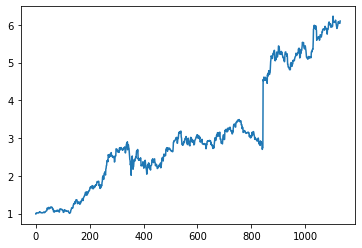

In [27]:
## with lfo filtering contaminatoin 0.00125
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


                 0
count  1086.000000
mean      0.002576
std       0.026996
min      -0.091320
25%      -0.005374
50%       0.000823
75%       0.008884
max       0.657393


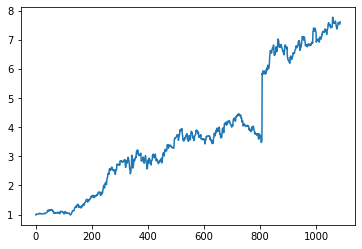

In [31]:
## with lfo filtering contaminatoin 0.0025
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


                 0
count  1024.000000
mean      0.002287
std       0.027527
min      -0.125263
25%      -0.005557
50%       0.000674
75%       0.008249
max       0.657393


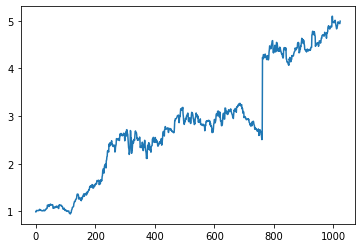

In [7]:
## with lfo filtering contaminatoin 0.005
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


                0
count  944.000000
mean     0.001879
std      0.017674
min     -0.125263
25%     -0.005391
50%      0.000844
75%      0.008581
max      0.087372


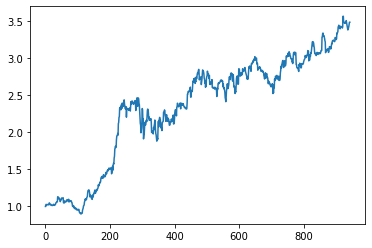

In [5]:
## with lfo filtering contaminatoin 0.01
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


                0
count  529.000000
mean     0.001242
std      0.016346
min     -0.062841
25%     -0.005099
50%      0.000970
75%      0.007277
max      0.080179


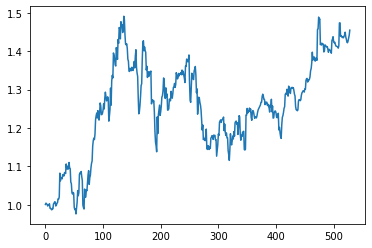

In [3]:
## with lfo filtering contaminatoin 0.05
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


                 0
count  1354.000000
mean      0.001845
std       0.026725
min      -0.146145
25%      -0.005765
50%       0.000763
75%       0.008464
max       0.660410


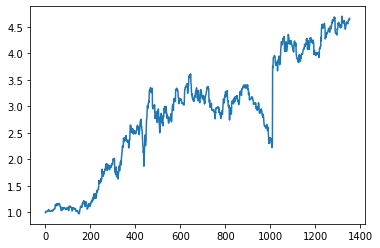

In [474]:
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


In [502]:
pos = np.where(regressor.predict(X_test) > 0, y_test, np.NaN)
neg = np.where(regressor.predict(X_test) < 0, y_test, np.NaN)

pd.DataFrame(pos).describe(),pd.DataFrame(neg).describe()

(                0
 count  169.000000
 mean     0.001754
 std      0.012219
 min     -0.049710
 25%     -0.003278
 50%      0.001549
 75%      0.006292
 max      0.051747,
                 0
 count  166.000000
 mean     0.000154
 std      0.012990
 min     -0.063616
 25%     -0.003900
 50%      0.000031
 75%      0.003577
 max      0.058967)

In [11]:
from scipy.stats import kurtosis, skew
## autoregressive predict based on past trades
def extract_features_from_window(window):
    return [
        #np.mean(window),
        np.std(window),
        kurtosis(window),
        skew(window)
    ]
def extract_features_from_window(window):
    # Grundlegende statistische Merkmale
    features = [
        #np.mean(window),
        np.std(window),
        kurtosis(window),
        skew(window)
    ]
    
    return features

def prepare_data_with_features(trades, window_sizes=[10, 20, 30, 40, 50], history_size=15):
    X, y = [], []
    for i in range(max(window_sizes), len(trades) - 1):
        features = []
        
        for window_size in window_sizes:
            window = trades[i-window_size:i]
            features.extend(extract_features_from_window(window))
        
        # Die letzten 'history_size' Werte als Features hinzufügen
        features.extend(trades[i-history_size:i])
        
        X.append(features)
        y.append(trades[i+1])
        
    return np.array(X), np.array(y)

window_sizes = [5, 10, 25]#, 25, 50, 100]
history_size = 3
# Daten vorbereiten
X, y = prepare_data_with_features(gains_v3, window_sizes, history_size)
train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modell trainieren
regressor = RandomForestRegressor(random_state=0)
regressor.fit(X_train, y_train)

# Vorhersagen auf dem Testdatensatz
y_pred = regressor.predict(X_test)

# Modell auswerten
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

pos = np.where(regressor.predict(X_test) > 0, y_test, np.NaN)
neg = np.where(regressor.predict(X_test) < 0, y_test, np.NaN)

pd.DataFrame(pos).describe(),pd.DataFrame(neg).describe()


NameError: name 'RandomForestRegressor' is not defined

In [21]:
from sklearn.linear_model import LinearRegression

def walk_forward_evaluation(trades, window_sizes=[5, 15, 50], history_size=5):
    # Die Daten vorbereiten
    X, y = prepare_data_with_features(trades, window_sizes, history_size)

    initial_train_size = max(window_sizes) + history_size  # Mindestens so viele Datenpunkte benötigen wir für die Feature-Extraktion
    predictions = []
    true_values = []

    for i in range(initial_train_size, len(X)):
        # Daten bis zum aktuellen Punkt nehmen
        X_train, y_train = X[:i], y[:i]

        # Modell trainieren
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)

        # Den nächsten Punkt vorhersagen
        y_pred = regressor.predict([X[i]])
        
        true_values.append(y[i])

        if y_pred[0]>0:
            predictions.append(y[i])


    return true_values, predictions

true_values, predictions = walk_forward_evaluation(gains_v3)


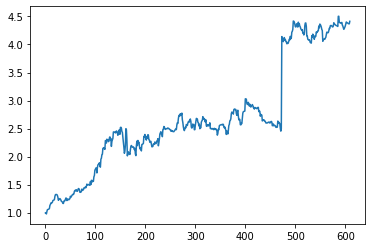

In [22]:
plt.plot(np.cumprod(1+np.array(predictions)-np.array(fees)))

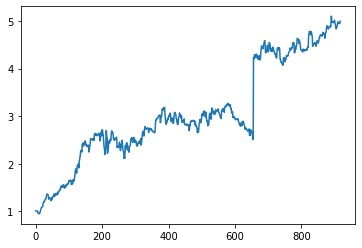

In [23]:
plt.plot(np.cumprod(1+np.array(true_values)-np.array(fees)))


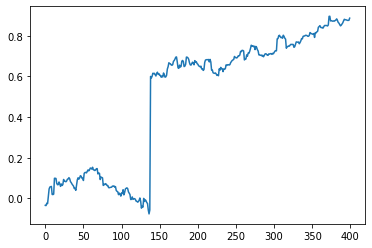

In [20]:
plt.plot(np.cumsum(pd.DataFrame(y_test).replace(np.NaN,0)))

                 0
count  1354.000000
mean      0.001845
std       0.026725
min      -0.146145
25%      -0.005765
50%       0.000763
75%       0.008464
max       0.660410


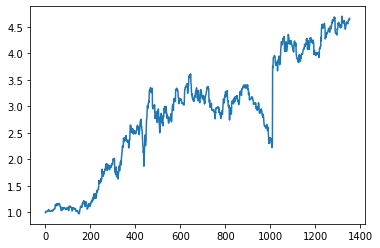

In [818]:
fees = .04/100
print(pd.DataFrame(gains_v3).describe())
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


In [590]:
pd.DataFrame(gains_v3).describe()

0
count  1354.000000
mean      0.001845
std       0.026725
min      -0.146145
25%      -0.005765
50%       0.000763
75%       0.008464
max       0.660410

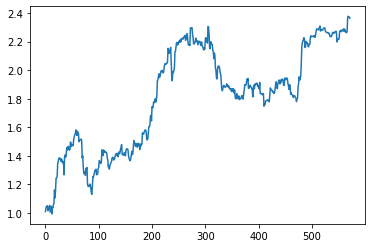

In [454]:
fees = .04/100
plt.plot(np.cumprod(1+1*(np.array(gains_v3)-np.array(fees))))


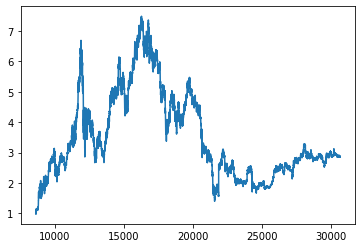

In [273]:
plt.plot(np.cumprod(1+df_trade["Close"].pct_change()[TRAIN_WINDOW_SIZE:]))

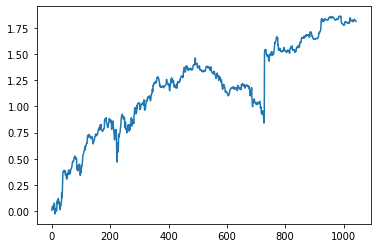

In [256]:
plt.plot(np.cumsum(np.array(gains_v3)-np.array(fees)))

In [278]:
## TP AND SL
def walk_forward_validation_with_tp(data, features, label, train_window, test_window, close_col="Close"):
    """
    Perform walk forward validation with trade simulation v2.
    """
    current_start = 0
    all_gains = []
    all_trade_entries = []
    all_trade_exits = []

    while current_start + train_window + test_window <= len(data):
        train_data, test_data = get_next_window_wf(data, current_start, train_window, test_window)
        model = train_model_wf(train_data[features], train_data[label])
        predictions = model.predict(test_data[features])
        truecount = np.count_nonzero(predictions & test_data.label.astype(bool))
        falsecount = np.count_nonzero(predictions & ~test_data.label.astype(bool))
        print("starting train data",train_data.Open_time.min(),"to",train_data.Open_time.max(), "oflen", len(test_data))

        print("starting eval month from",test_data.Open_time.min(),"to",test_data.Open_time.max(), "oflen", len(test_data))
        print("confusion:", confusion_matrix(test_data['label'], predictions))
        mtrue = predictions & test_data.label.astype(bool)
        mfalse = predictions & ~test_data.label.astype(bool)
        gains = 2*test_data.loc[mtrue, "true_range"]/test_data.loc[mtrue, "Close"]
        gains_neg = 1*test_data.loc[mfalse, "true_range"]/test_data.loc[mfalse, "Close"]
        gains = np.sum(gains)-np.sum(gains_neg)
        print("gains:", gains, "nr of trades", np.count_nonzero(predictions))
        avg_gain = gains/np.count_nonzero(predictions)
        print("avg gain:", avg_gain)
        all_gains.append(avg_gain)
        
        current_start += test_window

    return all_gains

df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v2.csv')
df_trade["label"] = df_trade.label.replace(np.NaN,False)

HOURS_IN_MONTH = 24 * 30
TRAIN_WINDOW_SIZE = 12 * HOURS_IN_MONTH  
TRAIN_WINDOW_SIZE = int(TRAIN_WINDOW_SIZE)
TEST_WINDOW_SIZE = 14*24


# Drop rows with NaN values
df_trade_cleaned = df_trade.replace(np.NaN,0)

# Convert boolean labels to binary (0 and 1)
df_trade_cleaned["label"] = df_trade_cleaned["label"].astype(int)

# Extract features and label
features_trade = df_trade_cleaned.columns[df_trade_cleaned.columns.str.contains("Feature")].tolist()
label_trade = "label"

df_trade_cleaned.head()

# Perform Walk Forward Validation with the trade simulation v3
gains_v3 = walk_forward_validation_with_tp(df_trade_cleaned, features_trade, label_trade, TRAIN_WINDOW_SIZE, TEST_WINDOW_SIZE)


# Constants for our data



"""# Plot cumulative gains and trade entry/exits using open_time v3
plt.figure(figsize=(15, 7))
plt.plot(df_trade_cleaned["Open_time"], df_trade_cleaned["Close"], label="Close Price", alpha=0.6)
#plt.plot(df_trade_cleaned["Open_time"], np.cumprod([1] + gains_v3), label="Cumulative Gain", color="green", lw=2)
plt.scatter(trade_entries_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_entries_times_v3)], marker="^", color="g", label="Trade Entry")
plt.scatter(trade_exits_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_exits_times_v3)], marker="v", color="r", label="Trade Exit")
plt.legend()
plt.title("Close Price with Trade Entry/Exits and Cumulative Gain (V3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


<ipython-input-278-c7fc6551d796>:34: DtypeWarning: Columns (129) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v2.csv')


args in 0 8640 336
testdata indices: 8640 8976
testdata length: 336
extracted month from 2020-12-26 17:00:00 to 2021-01-09 16:00:00
starting train data 2020-01-01 00:00:00 to 2020-12-26 16:00:00 oflen 336
starting eval month from 2020-12-26 17:00:00 to 2021-01-09 16:00:00 oflen 336
confusion: [[144   9]
 [173  10]]
gains: 0.12500288260033354 nr of trades 19
avg gain: 0.006579099084228081
args in 336 8640 336
testdata indices: 8976 9312
testdata length: 336
extracted month from 2021-01-09 17:00:00 to 2021-01-23 16:00:00
starting train data 2020-01-15 00:00:00 to 2021-01-09 16:00:00 oflen 336
starting eval month from 2021-01-09 17:00:00 to 2021-01-23 16:00:00 oflen 336
confusion: [[180  13]
 [134   9]]
gains: -0.061125675245400746 nr of trades 22
avg gain: -0.002778439783881852
args in 672 8640 336
testdata indices: 9312 9648
testdata length: 336
extracted month from 2021-01-23 17:00:00 to 2021-02-06 16:00:00
starting train data 2020-01-29 00:00:00 to 2021-01-23 16:00:00 oflen 336
starti

<ipython-input-278-c7fc6551d796>:27: RuntimeWarning: invalid value encountered in scalar divide
  avg_gain = gains/np.count_nonzero(predictions)


starting train data 2021-12-16 06:00:00 to 2023-01-11 05:00:00.000 oflen 336
starting eval month from 2023-01-11 06:00:00.000 to 2023-01-25 05:00:00.000 oflen 336
confusion: [[183   3]
 [141   9]]
gains: 0.1209917615284388 nr of trades 12
avg gain: 0.010082646794036566
args in 17472 8640 336
testdata indices: 26112 26448
testdata length: 336
extracted month from 2023-01-25 06:00:00.000 to 2023-02-08 05:00:00.000
starting train data 2021-12-30 06:00:00 to 2023-01-25 05:00:00.000 oflen 336
starting eval month from 2023-01-25 06:00:00.000 to 2023-02-08 05:00:00.000 oflen 336
confusion: [[177  26]
 [106  27]]
gains: 0.1936109068818159 nr of trades 53
avg gain: 0.0036530359789021865
args in 17808 8640 336
testdata indices: 26448 26784
testdata length: 336
extracted month from 2023-02-08 06:00:00.000 to 2023-02-22 05:00:00.000
starting train data 2022-01-13 06:00:00 to 2023-02-08 05:00:00.000 oflen 336
starting eval month from 2023-02-08 06:00:00.000 to 2023-02-22 05:00:00.000 oflen 336
conf

'# Plot cumulative gains and trade entry/exits using open_time v3\nplt.figure(figsize=(15, 7))\nplt.plot(df_trade_cleaned["Open_time"], df_trade_cleaned["Close"], label="Close Price", alpha=0.6)\n#plt.plot(df_trade_cleaned["Open_time"], np.cumprod([1] + gains_v3), label="Cumulative Gain", color="green", lw=2)\nplt.scatter(trade_entries_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_entries_times_v3)], marker="^", color="g", label="Trade Entry")\nplt.scatter(trade_exits_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_exits_times_v3)], marker="v", color="r", label="Trade Exit")\nplt.legend()\nplt.title("Close Price with Trade Entry/Exits and Cumulative Gain (V3)")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

In [279]:
pd.DataFrame(gains_v3).describe()

0
count  64.000000
mean    0.002081
std     0.007541
min    -0.030043
25%    -0.001157
50%     0.002047
75%     0.006269
max     0.022614

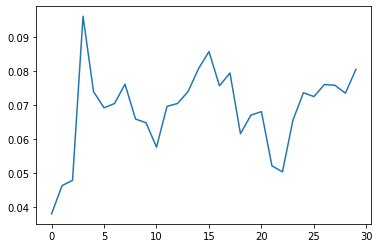

In [248]:
fees = .04/100
gains_v3 = np.array(gains_v3)
gains_v3 = np.where(~np.isnan(gains_v3), gains_v3, 0)
plt.plot(np.cumsum(np.array(gains_v3)-np.array(fees)))

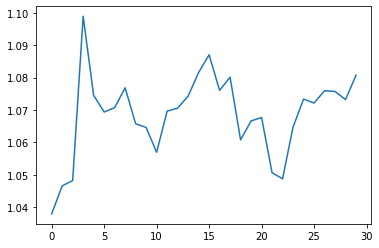

In [249]:
plt.plot(np.cumprod(1+np.array(gains_v3)-np.array(fees)))

In [85]:
# 1. Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 2. Load the dataset
df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v1.csv')
df_trade_cleaned = df_trade.dropna()
df_trade_cleaned["label"] = df_trade_cleaned["label"].astype(int)

# 3. Extract features
features_trade = df_trade_cleaned.columns[df_trade_cleaned.columns.str.contains("Feature")].tolist()

# 4. Split data into train and test
train_data, test_data = train_test_split(df_trade_cleaned, test_size=0.2, random_state=42)

# 5. Scale the features using the train data
scaler = StandardScaler().fit(train_data[features_trade])
scaled_train_features = scaler.transform(train_data[features_trade])
scaled_test_features = scaler.transform(test_data[features_trade])

# 6. Apply KMeans clustering only on the train data
kmeans = KMeans(n_clusters=3, random_state=42)
train_data['Cluster'] = kmeans.fit_predict(scaled_train_features)
test_data['Cluster'] = kmeans.predict(scaled_test_features)

print(train_data.Cluster.describe())
# 7. Train a classifier for each cluster using the train data
classifiers = {}
for cluster in train_data['Cluster'].unique():
    X_train = train_data[train_data['Cluster'] == cluster][features_trade]
    y_train = train_data[train_data['Cluster'] == cluster]['label']
    
    clf = SVC(probability=True)
    clf.fit(X_train, y_train)
    
    classifiers[cluster] = clf

# 8. Predict and evaluate on the test set
test_data_predictions = []
for idx, row in test_data.iterrows():
    # Determine the cluster of the data point
    cluster = row['Cluster']
    
    # Use the corresponding classifier to make the prediction
    prediction = classifiers[cluster].predict([row[features_trade]])[0]
    test_data_predictions.append(prediction)



<ipython-input-85-fca33738a189>:9: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v1.csv')
<ipython-input-85-fca33738a189>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_cleaned["label"] = df_trade_cleaned["label"].astype(int)
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


count    8578.000000
mean        0.646304
std         0.673183
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: Cluster, dtype: float64


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid fe

[-0.02163433548357053,
 -0.02580584176198132,
 0.004293857809145446,
 0.0036555645816409364,
 -0.06097775543546574,
 -0.0015313935681470717,
 -0.0024937069188604283,
 -0.001472963983654862,
 0.02453309038849483,
 -0.010115740740740752,
 0.04196982891816725,
 -0.0028640789940263802,
 -0.01361672057184788,
 -0.007397057614859836,
 -0.00439337614058803,
 0.011725571725571775,
 0.015808731111918068,
 0.004011319614253866,
 -0.007073686408603368,
 0.0036210660844560776,
 0.003483850059414553,
 0.0013278801720932702,
 -0.013379556903743173,
 -0.0036612021857922814,
 -0.012297663717783706,
 0.00030411943599672006,
 -0.0027350053332603997,
 0.00797105392023507,
 0.0017394512821863536,
 -0.002579083109637397,
 0.02356706430026192,
 -0.010841787346085312,
 0.0007821982467970882,
 0.006701546058432698,
 -0.011368856224161632,
 0.008961100011752295,
 -0.005904533629534473,
 0.00777080523136483,
 -0.03961634695579653,
 0.009915190820653372,
 0.0627434143947991,
 -0.004942625083099795,
 0.0148318302

In [889]:
len(predictions)

1289

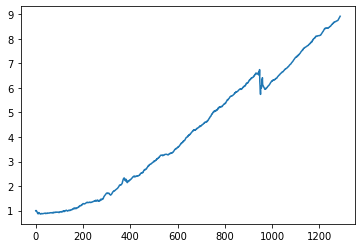

In [887]:
plt.plot(np.cumprod(np.array(predictions)+1-np.array(fees)))

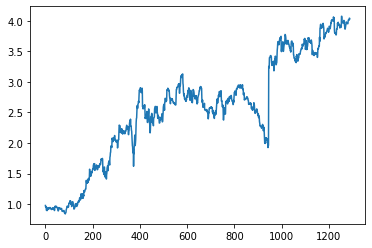

In [890]:
plt.plot(np.cumprod(np.array(true_values)+1-np.array(fees)))

In [90]:

report = classification_report(test_data['label'], test_data_predictions)
conf_matrix = confusion_matrix(test_data['label'], test_data_predictions)

print(report)
print(conf_matrix)


              precision    recall  f1-score   support

           0       0.63      0.98      0.77      1315
           1       0.74      0.10      0.17       830

    accuracy                           0.64      2145
   macro avg       0.68      0.54      0.47      2145
weighted avg       0.67      0.64      0.54      2145

[[1286   29]
 [ 749   81]]


In [87]:
print(conf_matrix)

<function confusion_matrix at 0x000001925DCF4AF0>


In [78]:
# 8. Predict and evaluate on the test set
test_data_predictions = []
for idx, row in test_data.iterrows():
    # Determine the cluster of the data point
    cluster = row['Cluster']
    
    # Use the corresponding classifier to make the prediction
    proba = classifiers[cluster].predict_proba([row[features_trade]])[0][1]  
    prediction = proba > .5
    test_data_predictions.append(prediction)


    # 9. Evaluate the predictions
(test_data['label'], test_data_predictions)


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid fe

In [80]:

print(report)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.63      0.96      0.76      1315
           1       0.66      0.12      0.21       830

    accuracy                           0.64      2145
   macro avg       0.65      0.54      0.48      2145
weighted avg       0.64      0.64      0.55      2145

[[1263   52]
 [ 729  101]]


In [76]:
# 8. Predict and evaluate on the train set
test_data_predictions = []
for idx, row in train_data.iterrows():
    # Determine the cluster of the data point
    cluster = row['Cluster']
    
    # Use the corresponding classifier to make the prediction
    proba = classifiers[cluster].predict_proba([row[features_trade]])[0][1]  
    prediction = proba > .5
    test_data_predictions.append(prediction)


    # 9. Evaluate the predictions

report = classification_report(train_data['label'], test_data_predictions)
conf_matrix = confusion_matrix(train_data['label'], test_data_predictions)


C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid fe

In [77]:

print(report)
print(conf_matrix)


              precision    recall  f1-score   support

           0       0.66      0.96      0.78      5393
           1       0.71      0.16      0.25      3185

    accuracy                           0.66      8578
   macro avg       0.68      0.56      0.52      8578
weighted avg       0.68      0.66      0.59      8578

[[5189  204]
 [2691  494]]


<ipython-input-176-c2dea57687bf>:13: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v1.csv')
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\xyz\anaconda3\envs\basic\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

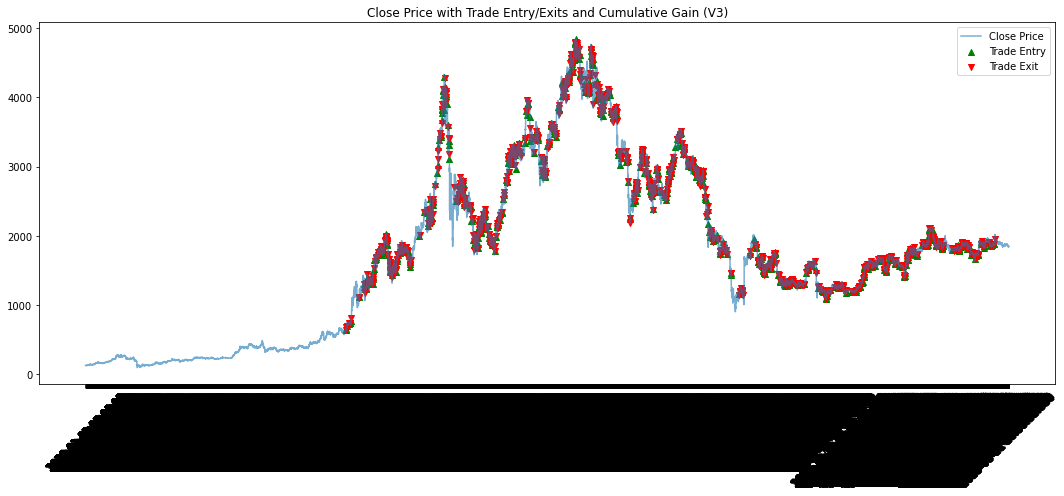

In [176]:
## WITH KMEANS BBRANCHING

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df_trade = pd.read_csv('eth1h_withlabel_andfeatures_v1.csv')
df_trade_cleaned = df_trade.replace(np.NaN,0)
df_trade_cleaned["label"] = df_trade_cleaned["label"].astype(int)

# Extract features and label
features_trade = df_trade_cleaned.columns[df_trade_cleaned.columns.str.contains("Feature")].tolist()
label_trade = "label"


# Update the train_model_wf function to include clustering
def train_model_wf(X_train, y_train):
    # 1. Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(X_train)
    
    # 2. Apply KMeans clustering on the train data
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # 3. Train a classifier for each cluster
    classifiers = {}
    for cluster in np.unique(clusters):
        cluster_data = scaled_features[clusters == cluster]
        cluster_labels = y_train[clusters == cluster]
        
        clf = SVC(probability=True)
        clf.fit(cluster_data, cluster_labels)
        
        classifiers[cluster] = clf
        
    return scaler, kmeans, classifiers

# Update the evaluate_model_wf function to return predictions
def evaluate_model_wf(model, X_test):
    scaler, kmeans, classifiers = model
    
    # Scale the features and predict clusters
    scaled_features = scaler.transform(X_test)
    clusters = kmeans.predict(scaled_features)
    
    # Use the corresponding classifier for each cluster to make predictions
    predictions = []
    for i, cluster in enumerate(clusters):
        prediction = classifiers[cluster].predict([scaled_features[i]])[0]
        predictions.append(prediction)
    
    return predictions

def walk_forward_validation_with_trades_v2(data, features, label, train_window, test_window, close_col="Close"):
    """
    Perform walk forward validation with trade simulation v2.
    """
    current_start = 0
    all_gains = []
    all_trade_entries = []
    all_trade_exits = []

    while current_start + train_window + test_window <= len(data):
        train_data, test_data = get_next_window_wf(data, current_start, train_window, test_window)
        model = train_model_wf(train_data[features], train_data[label])
        predictions = evaluate_model_wf(model, test_data[features])
        gains, trade_entries, trade_exits = simulate_trades_v3(test_data, predictions, close_col)
        
        all_gains.extend(gains)
        all_trade_entries.extend(trade_entries)
        all_trade_exits.extend(trade_exits)
        
        current_start += test_window

    return all_gains, all_trade_entries, all_trade_exits



# Define core functions and main function for Walk Forward Validation

def get_next_window_wf(data, start_index, train_window, test_window):
    end_train_window = start_index + train_window
    start_test_window = end_train_window
    end_test_window = start_test_window + test_window
    
    train_data = data.iloc[start_index:end_train_window]
    test_data = data.iloc[start_test_window:end_test_window]
    
    return train_data, test_data

def simulate_trades_v3(data, predictions, close_col="Close"):
    """
    Simulation of trades using open_time for trade entry and exit points.
    """
    in_trade = False
    entry_price = 0
    gains = []
    trade_entries_times = []
    trade_exits_times = []

    for i in range(1, len(predictions)):
        if predictions[i] == 1 and predictions[i - 1] == 0:  # Buy signal
            in_trade = True
            entry_price = data[close_col].iloc[i]
            trade_entries_times.append(data["Open_time"].iloc[i])
            
        elif in_trade and predictions[i] == 0 and predictions[i - 1] == 1:  # Sell signal
            in_trade = False
            exit_price = data[close_col].iloc[i]
            gain = (exit_price - entry_price) / entry_price
            gains.append(gain)
            trade_exits_times.append(data["Open_time"].iloc[i])

    # If still in trade at the end, sell at last price
    if in_trade:
        exit_price = data[close_col].iloc[-1]
        gain = (exit_price - entry_price) / entry_price
        gains.append(gain)
        trade_exits_times.append(data["Open_time"].iloc[-1])

    return gains, trade_entries_times, trade_exits_times
HOURS_IN_MONTH = 24 * 30
TRAIN_WINDOW_SIZE = 12 * HOURS_IN_MONTH  
TEST_WINDOW_SIZE = 30*24

# Perform Walk Forward Validation with the trade simulation v3
gains_v3, trade_entries_times_v3, trade_exits_times_v3 = walk_forward_validation_with_trades_v2(df_trade_cleaned, features_trade, label_trade, TRAIN_WINDOW_SIZE, TEST_WINDOW_SIZE)

# Plot cumulative gains and trade entry/exits using open_time v3
plt.figure(figsize=(15, 7))
plt.plot(df_trade_cleaned["Open_time"], df_trade_cleaned["Close"], label="Close Price", alpha=0.6)
plt.scatter(trade_entries_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_entries_times_v3)], marker="^", color="g", label="Trade Entry")
plt.scatter(trade_exits_times_v3, df_trade_cleaned["Close"][df_trade_cleaned["Open_time"].isin(trade_exits_times_v3)], marker="v", color="r", label="Trade Exit")
plt.legend()
plt.title("Close Price with Trade Entry/Exits and Cumulative Gain (V3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [177]:
pd.DataFrame(gains_v3).describe()

0
count  953.000000
mean     0.000131
std      0.022516
min     -0.130033
25%     -0.006895
50%      0.000225
75%      0.007395
max      0.098962